## Plot bandwidth CDF

In [4]:
import pandas as pd
import numpy as np
from plot_cdf import plot_cdf, plot_cdf_multiple
import matplotlib.pyplot as plt
import json
import os
import glob
import sys
import itertools
from collections import defaultdict

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from conf_dict_util import conf_to_dict, dict_to_conf
from qoe_utils import make_bandwidth_series, get_QoE_rr, get_QoE_delay, get_QoE_losses

In [5]:
# parent_folder = "../new_data/logs_all_4G_Ghent_json"
# parent_folder = "../new_data/Norway_3G_data_json"
parent_folder = "../new_data/NY_4G_data_json"

traces = [os.path.join(parent_folder, log_file) for log_file \
          in os.listdir(parent_folder) if "json" in log_file]
step_time = 200
print("Num traces: ", len(traces))
print("First five: ", traces[:5])

Num traces:  27
First five:  ['../new_data/NY_4G_data_json/Bus_B57_bus57_1.json', '../new_data/NY_4G_data_json/7Train_7BtrainNew.json', '../new_data/NY_4G_data_json/Ferry_Ferry2.json', '../new_data/NY_4G_data_json/Subway_D_Train_d1.json', '../new_data/NY_4G_data_json/Subway_7Train_7Train1.json']


In [9]:
d_capacities = {}
lolo_capacities = []
std_cap = []
std_first_10s = []
durations = []
capacities_max = []
capacities_p90 = []
max_first_10s = []
for trace_path in traces:

    trace = os.path.basename(trace_path).split(".")[0]
    print(trace_path)
    d_capacities[trace] = {}

    capacities = make_bandwidth_series(trace_path, step_time)
    print(capacities)
    duration = (capacities.index[-1] - capacities.index[0]).total_seconds()
    p90 = capacities.quantile(0.9)
    first_10_s_series = capacities[:"1970-01-01 00:00:10.000"]
    # print(first_10_s_series)
    
    std_cap.append(capacities.std())
    lolo_capacities.append(list(capacities))
    durations.append(duration)
    capacities_max.append(capacities.max())
    capacities_p90.append(p90)
    max_first_10s.append(first_10_s_series.max())
    std_first_10s.append(first_10_s_series.std())
    
    
    d_capacities[trace]["max_first_10s"] = first_10_s_series.max()
    d_capacities[trace]["std_first_10s"] = first_10_s_series.std()
    d_capacities[trace]["std"] = capacities.std()
    d_capacities[trace]["min"] = capacities.min()
    d_capacities[trace]["max"] = capacities.max()
    d_capacities[trace]["mean"] = capacities.mean()
    d_capacities[trace]["median"] = capacities.median()
    d_capacities[trace]["p90"] = p90
    d_capacities[trace]["capacities_series"] = capacities
    d_capacities[trace]["first_10s_series"] = first_10_s_series
    d_capacities[trace]["duration"] = duration #duration in seconds
    
    # print(capacities.max(), p90, first_10_s_series.max())
    # print("Real max", capacities.max())
    # print("Difference between real max and first 10s max: ", capacities.max() - first_10_s_series.max())
    # print("Difference between real max and p90: ", capacities.max() - p90)
    # print("------------------------------------")

../new_data/NY_4G_data_json/Bus_B57_bus57_1.json
1970-01-01 00:00:00.000    3970.0
1970-01-01 00:00:00.200    3970.0
1970-01-01 00:00:00.400    3970.0
1970-01-01 00:00:00.600    3970.0
1970-01-01 00:00:00.800    3970.0
                            ...  
1970-01-01 00:40:02.200    6210.0
1970-01-01 00:40:02.400    6210.0
1970-01-01 00:40:02.600    6210.0
1970-01-01 00:40:02.800    6210.0
1970-01-01 00:40:03.000    6210.0
Freq: 200L, Length: 12016, dtype: float64
../new_data/NY_4G_data_json/7Train_7BtrainNew.json
1970-01-01 00:00:00.000    1010.0
1970-01-01 00:00:00.200    1010.0
1970-01-01 00:00:00.400    1010.0
1970-01-01 00:00:00.600    1010.0
1970-01-01 00:00:00.800    1010.0
                            ...  
1970-01-01 03:30:58.200    3140.0
1970-01-01 03:30:58.400    3140.0
1970-01-01 03:30:58.600    3140.0
1970-01-01 03:30:58.800    3140.0
1970-01-01 03:30:59.000    3140.0
Freq: 200L, Length: 63296, dtype: float64
../new_data/NY_4G_data_json/Ferry_Ferry2.json
1970-01-01 00:00:00.00

TypeError: unsupported operand type(s) for -: 'str' and 'str'

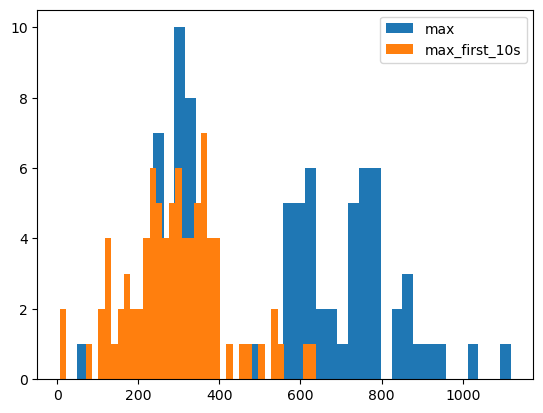

In [8]:
plt.figure()
plt.hist(capacities_max, bins=40, label="max")
plt.hist(max_first_10s, bins=40, label="max_first_10s")
plt.legend()

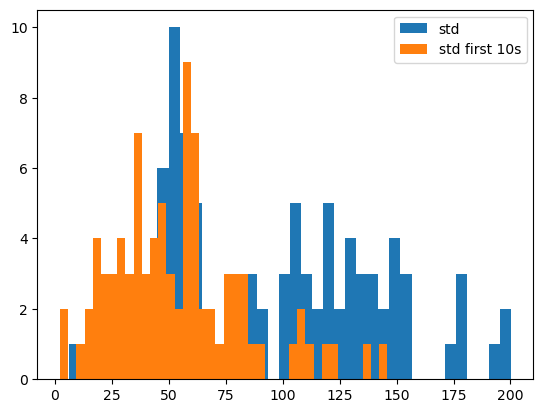

In [9]:
plt.figure()
plt.hist(std_cap, bins=40, label="std")
plt.hist(std_first_10s, bins=40, label="std first 10s")
plt.legend()

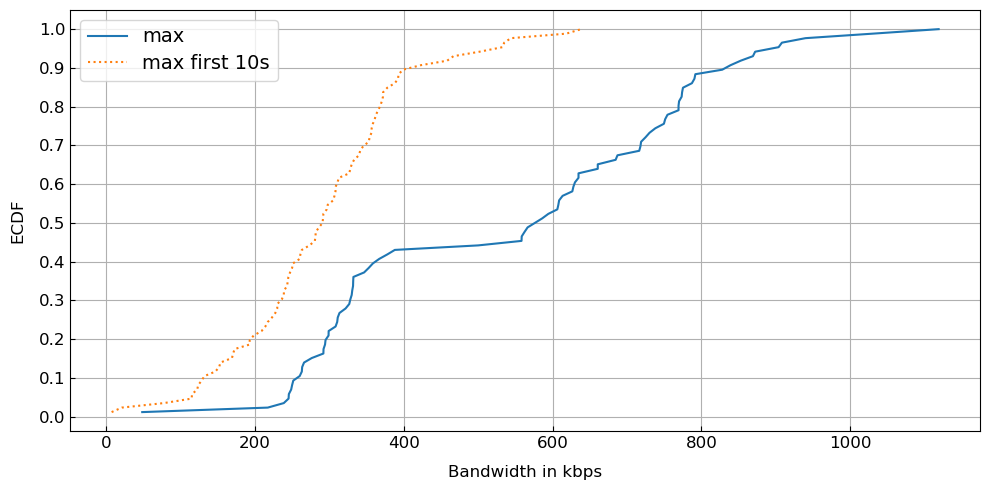

In [10]:
from plot_cdf import plot_cdf_multiple

plot_cdf_multiple([capacities_max, max_first_10s], "Bandwidth in kbps", legend=["max", "max first 10s"])

## How much is the std in the first 10s a representative of the actual std

<StemContainer object of 3 artists>

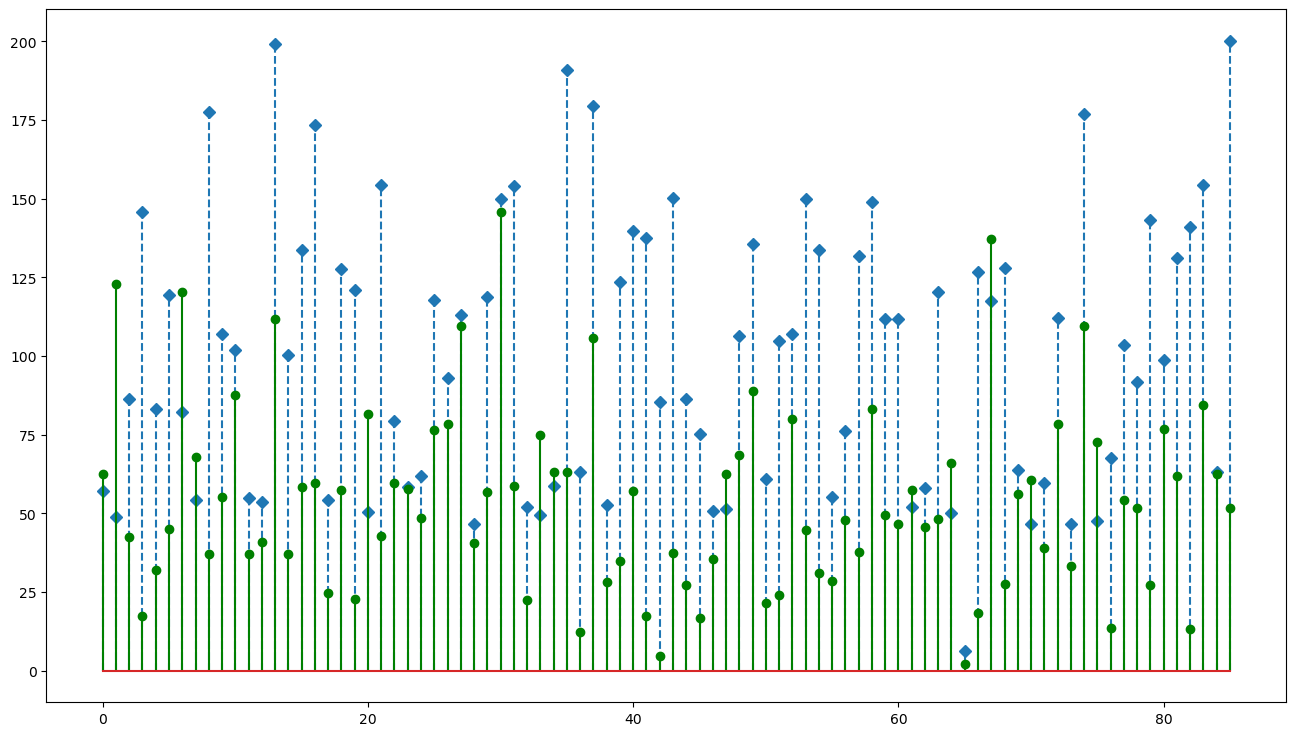

In [11]:
plt.figure(figsize=(16,9))
plt.stem(std_cap, markerfmt='D', basefmt=" ", linefmt="--")
# plt.setp(baseline, visible=False)
plt.stem(std_first_10s, "g")

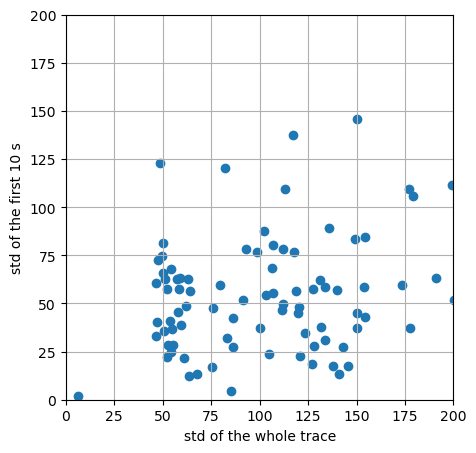

In [12]:
plt.figure(figsize=(5,5))
plt.scatter(std_cap, std_first_10s)
plt.xlim(0,200)
plt.ylim(0,200)
plt.xlabel("std of the whole trace")
plt.ylabel("std of the first 10 s")
plt.grid()

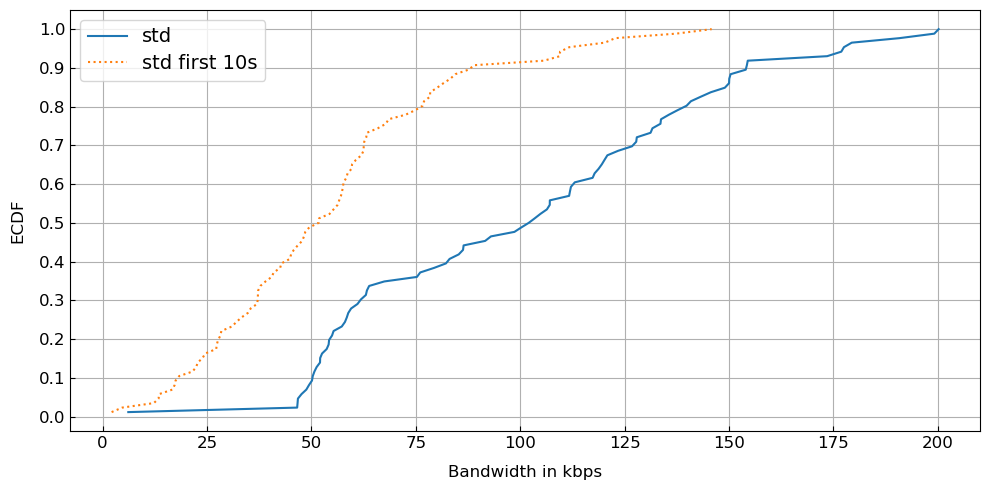

In [13]:
from plot_cdf import plot_cdf_multiple

plot_cdf_multiple([std_cap, std_first_10s], "Bandwidth in kbps", legend=["std", "std first 10s"])

In [14]:
for key, value in d_capacities.items():
    break

bus_2010-11-10_1424CET Max  534.9119683481701 Std  87.61679884413269
bus_2010-09-30_1114CEST Max  638.3256743256743 Std  111.7645993233622
bus_2010-09-29_1622CEST Max  501.9840637450199 Std  76.65528253030664
ferry_2011-02-01_0740CET Max  466.65634365634367 Std  145.85741487453453
ferry_2011-02-01_1639CET Max  458.2061446977205 Std  105.67583002339232
ferry_2011-02-01_0629CET Max  422.7703213610586 Std  89.01287117115672
bus_2010-09-29_1823CEST Max  532.563492063492 Std  83.28974637380699
ferry_2011-02-01_0840CET Max  543.8661338661339 Std  137.31021091212128
bus_2010-09-29_0852CEST Max  618.2857142857143 Std  84.45404791873118
Number of traces plotted:  9


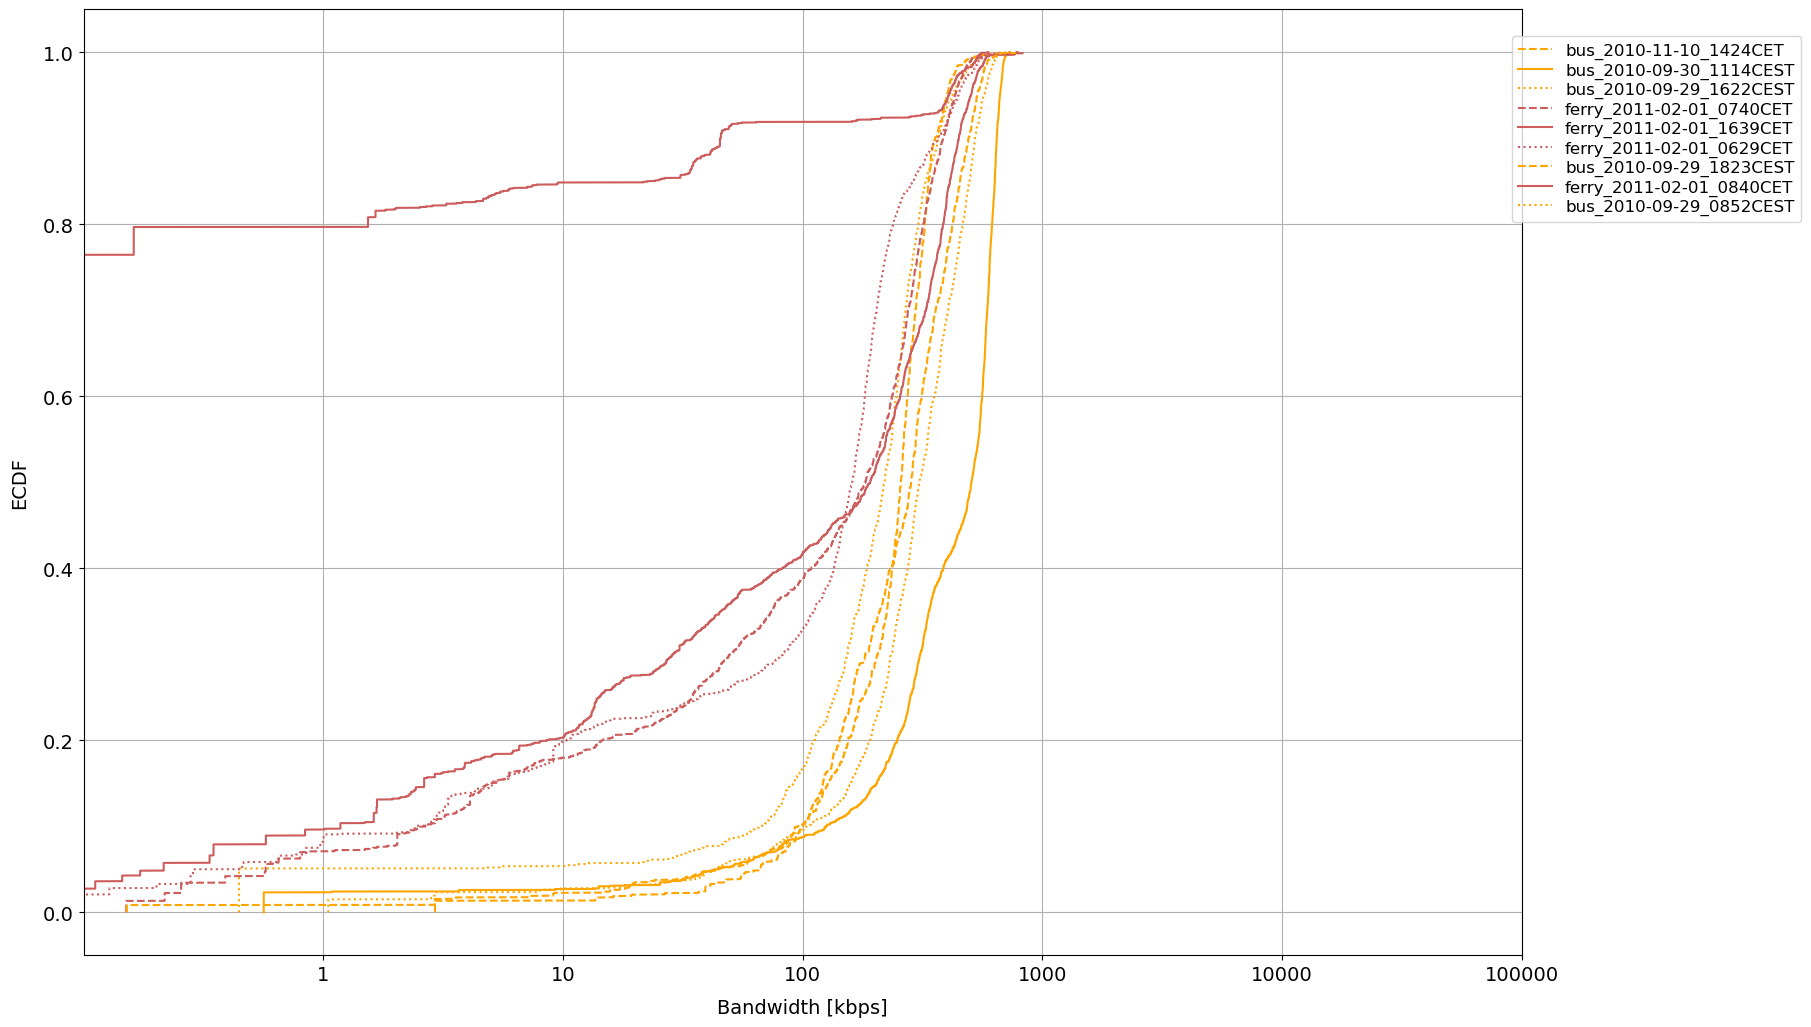

In [17]:
traces_to_train_on = []

list_cdf_data = lolo_capacities

figsize = (15, 10)
labelspacing = 0.2
legend_fontsize = 12
fontsize = 14
x_label = "Bandwidth [kbps]"

colors_dataset = ["#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
linestyles = ["dashed", "solid", "dotted", "dashdot", (0, (3, 1, 1, 1))]
colors_dataset = ["indianred", "teal", "lightgreen"]
cd = itertools.cycle(colors_dataset)

fig, ax = plt.subplots(figsize=figsize)
ax.tick_params(axis='both', which='minor',
               length=0,
               # direction='in'
              )
ax.tick_params(axis='both', which='major',
               #length=0,
               # direction='in'
              )
c = 0
for i in range(len(list_cdf_data)):

    data = list_cdf_data[i]
#     label = trace_dict[traces[i]]
    label = os.path.basename(traces[i]).split(".")[0]
    
    if ((d_capacities[label]["max_first_10s"] >= 400) and (d_capacities[label]["max_first_10s"] <= 1000)) \
        and ((d_capacities[label]["std_first_10s"] >= 0) and (d_capacities[label]["std_first_10s"] <= 1000)):
        print(label, "Max ", d_capacities[label]["max_first_10s"], "Std ", d_capacities[label]["std_first_10s"])
    
    # if d_capacities[label]["std"] > 100:
    # if "metro" in label or "ferry" in label:
        
        traces_to_train_on.append(traces[i])

    
        if c%3 == 0:
            ls = itertools.cycle(linestyles)
        c+=1

        cdfx = np.sort(data)
        cdfy = np.linspace(1 / len(data), 1.0, len(data))
        if "car" in label:
            color = "royalblue"
        elif "bus" in label:
            color = "orange"
        elif "foot" in label:
            color = "indianred"
        elif "train" in label:
            color = "green"
        elif "tram" in label:
            color = "lightblue"
        elif "metro" in label:
            color = "black"
        elif "ferry" in label:
            color = "indianred"

        p = plt.plot(cdfx, cdfy,
                     linestyle=next(ls),
                     label=label,
                     color = color
                    )
        plt.tight_layout()
    
print("Number of traces plotted: ", c)

# plt.xticks(np.arange(0,26,2))
plt.xscale('log')
plt.yticks(np.arange(0,1.1,0.2))
ax.tick_params(axis='y', labelsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)

plt.xlabel(x_label, fontsize=fontsize, labelpad=10)
plt.xlim(0.1,100000)
plt.ylabel('ECDF', fontsize=fontsize, labelpad=10)
plt.grid()

plt.xticks([1, 10, 100, 1000, 10000, 100000], [1, 10, 100, 1000, 10000, 100000])

plt.legend(prop={'size': legend_fontsize}, labelspacing=labelspacing,
           bbox_to_anchor=(1.2,0.98)
          )

if "ghent" in parent_folder:
    plt.savefig("plots/bandwidth_ghent_bla.png",  bbox_inches='tight')
else:
    plt.savefig("plots/bandwidth_norway.png",  bbox_inches='tight')

# plt.savefig("plots/bandwidth_all_traces.pdf",  bbox_inches='tight')
# plt.savefig("plots/bandwidth_all_traces.png",  bbox_inches='tight', dpi=500, transparent=True)

In [18]:
["." + t.split("..")[1] for t in traces_to_train_on]

['./new_data/Norway_3G_data_json/bus_2010-11-10_1424CET.json',
 './new_data/Norway_3G_data_json/bus_2010-09-30_1114CEST.json',
 './new_data/Norway_3G_data_json/bus_2010-09-29_1622CEST.json',
 './new_data/Norway_3G_data_json/ferry_2011-02-01_0740CET.json',
 './new_data/Norway_3G_data_json/ferry_2011-02-01_1639CET.json',
 './new_data/Norway_3G_data_json/ferry_2011-02-01_0629CET.json',
 './new_data/Norway_3G_data_json/bus_2010-09-29_1823CEST.json',
 './new_data/Norway_3G_data_json/ferry_2011-02-01_0840CET.json',
 './new_data/Norway_3G_data_json/bus_2010-09-29_0852CEST.json']